In [9]:
#Libraries
library(leaps)
library(glmnet)
library(tidymodels)

# Linear Methods

In this notebook, we explore linear methods, or methods that are even less flexible

## 1. Data preparation

In [14]:
train <- read.csv(file = '../../Data/training_data.csv')
test <-  read.csv(file = '../../Data/test_data.csv')
train.regr <- train[,-3]
train.regr <- na.omit(train.regr)

#Declaring a function to remove predictors with 0 variance. This function returns the indices of the predicors with 0 variance.
ZeroVar <- function(data) {
    out <- lapply(data, function(x) length(unique(x)))
    want <- which(!out > 1)
    unlist(want)
}

#Applying the ZeroVar function
train.zeroVar <- train.regr[,-ZeroVar(train.regr)]

## 2. Basic linear fit

In [15]:
linear.fit1 <- lm(VALENCE.PLEASANTNESS ~ .,train.regr)
linear.fit2 <- lm(VALENCE.PLEASANTNESS ~ .,train.zeroVar)
#summary(linear.fit1)
#summary(linear.fit2)

We do not show the entire results for these fits as it unnecessarily polluts this file, the respective $adusted-R^2$ values are:
- 0.3205 for linear.fit1
- 0.532 for linear.fit2

## 3. Subset Selection
### Foward selection

In [2]:
less_variable.study.fw <- regsubsets(VALENCE.PLEASANTNESS ~ ., train.regr,nvmax = 100,really.big=T,method="forward")

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"4538  linear dependencies found"

Reordering variables and trying again:


In [16]:
#summary(less_variable.study)
#Printing the 10 most influent variables
coef(less_variable.study.fw,id = 10) 

ERROR: Error in coef(less_variable.study.fw, id = 10): objet 'less_variable.study.fw' introuvable


We do the same again with the data that has no zero variance predictors

In [3]:
#data.train <- train[,c(-3)]
#
#foo <- function(dat) {
#    out <- lapply(dat, function(x) length(unique(x)))
#    want <- which(!out > 1)
#    unlist(want)
#}                
#data.train.process <- data.train[,-foo(data.train)]
 
less_variable.study.fw2 <- regsubsets(VALENCE.PLEASANTNESS ~ ., train.zeroVar,nvmax = 500,really.big=T,method="forward")
coef(less_variable.study.fw2,id = 10)                   


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2696  linear dependencies found"

Reordering variables and trying again:


Warning message in rval$lopt[] <- rval$vorder[rval$lopt]:
"le nombre d'objets à remplacer n'est pas multiple de la taille du remplacement"

(Intercept)        MATS6i          JGI6    P_VSA_MR_2  Eig05_EA.dm. 
   43.9192931    13.4428892   359.2610360     0.1407271     8.9144291 
      RDF120m        HATS5v         nRNHR  CATS2D_03_NL      F01.C.S. 
  -12.2158196   -63.6578172   -24.2947635   -13.4447988    -6.6393971 
Depressant.50 
  -37.4410701

### Backward Selection

In [ ]:
#do not run (too long)
less_variable.study.bc <- regsubsets(VALENCE.PLEASANTNESS ~ ., train.regr,nvmax = 100,really.big=T,method="backward")


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"4538  linear dependencies found"

In [4]:
C <- coef(less_variable.study.fw,id = 100) 
coef(less_variable.study.fw,id = 10) 

(Intercept)        MATS6i          JGI6    P_VSA_MR_2  Eig05_EA.dm. 
   43.9192931    13.4428892   359.2610360     0.1407271     8.9144291 
      RDF120m        HATS5v         nRNHR  CATS2D_03_NL      F01.C.S. 
  -12.2158196   -63.6578172   -24.2947635   -13.4447988    -6.6393971 
Depressant.50 
  -37.4410701

In [5]:
predict.regsubsets <- function(object, newdata, id, form = as.formula(object$call[[2]])) {
    mat = model.matrix(form, newdata)
    coefi = coef(object, id=id)
    xvars = names(coefi)
    mat[,xvars]%*%coefi
}

In [13]:
Id.best.variables <- names(C)
Id.best.variables <- Id.best.variables[-1]
## !!!! Certaine variable enlevée sont en fait importante pour !!

In [20]:
Id.process <- names(coef(less_variable.study.fw2,id = 325))[-1]

## K fold Validation (for subset selection) 

In [14]:
#keep only the 100 most important variables.
m <- model.matrix(VALENCE.PLEASANTNESS ~ .,train.regr)
data.for.validation <- m[,Id.best.variables]
data.for.validation <- data.frame(data.for.validation)
data.for.validation$VALENCE.PLEASANTNESS <- train.regr[,"VALENCE.PLEASANTNESS"]
dim(data.for.validation)

[1] 708 101

In [18]:
validation_data <- vfold_cv(data.for.validation, v = 20) #v = nbr of fold !

fit_and_evaluate <- function(fold, formula) {
    best.fit.id <- regsubsets(formula, analysis(fold),really.big=T,method="forward",nvmax = 96)
    valid.set <- assessment(fold)
    sapply(seq(1, best.fit.id$nvmax - 1), function(id) mean((valid.set$VALENCE.PLEASANTNESS - predict.regsubsets(best.fit.id, valid.set, id, formula))^2))
}
v.errors <- sapply(validation_data$splits, fit_and_evaluate,VALENCE.PLEASANTNESS ~ .)
v.errors.id <- rowMeans(v.errors)

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1  linear dependencies found"

Reordering variables and trying again:


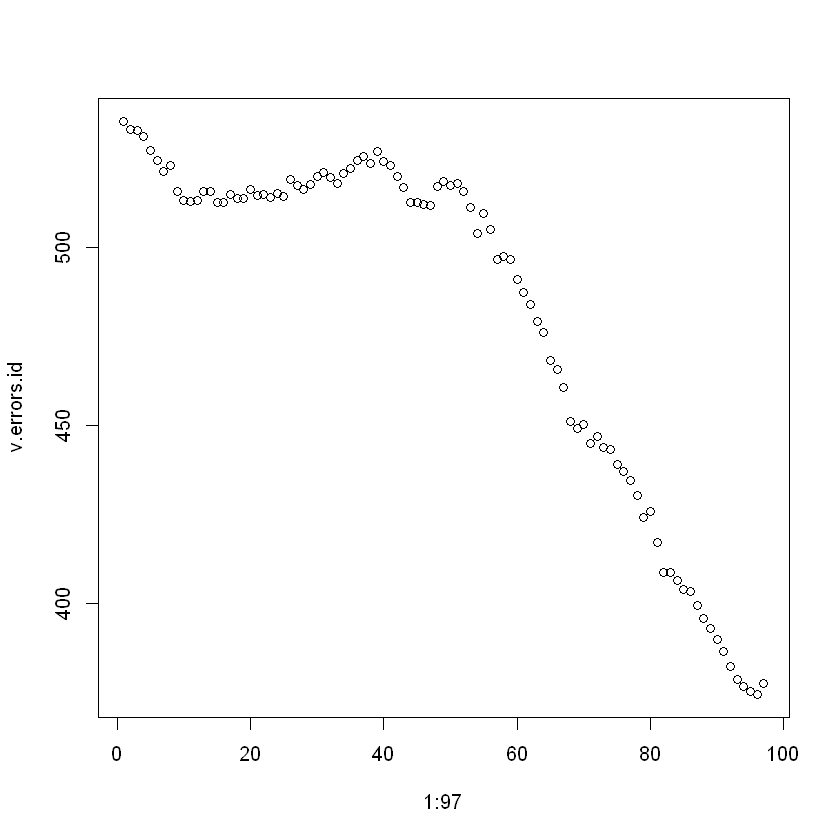

In [19]:
#v.errors.id
plot(1:97,v.errors.id)

In [21]:
m <- model.matrix(VALENCE.PLEASANTNESS ~ .,data.train.process)
data.for.validation <- m[,Id.process]
data.for.validation <- data.frame(data.for.validation)
data.for.validation$VALENCE.PLEASANTNESS <- train.regr[,"VALENCE.PLEASANTNESS"]


validation_data <- vfold_cv(data.for.validation, v = 25) #v = nbr of fold !

fit_and_evaluate <- function(fold, formula) {
    best.fit.id <- regsubsets(formula, analysis(fold),really.big=T,method="forward",nvmax = 200)
    valid.set <- assessment(fold)
    sapply(seq(1, best.fit.id$nvmax - 1), function(id) mean((valid.set$VALENCE.PLEASANTNESS - predict.regsubsets(best.fit.id, valid.set, id, formula))^2))
}
v.errors <- sapply(validation_data$splits, fit_and_evaluate,VALENCE.PLEASANTNESS ~ .)
v.errors.id <- rowMeans(v.errors)

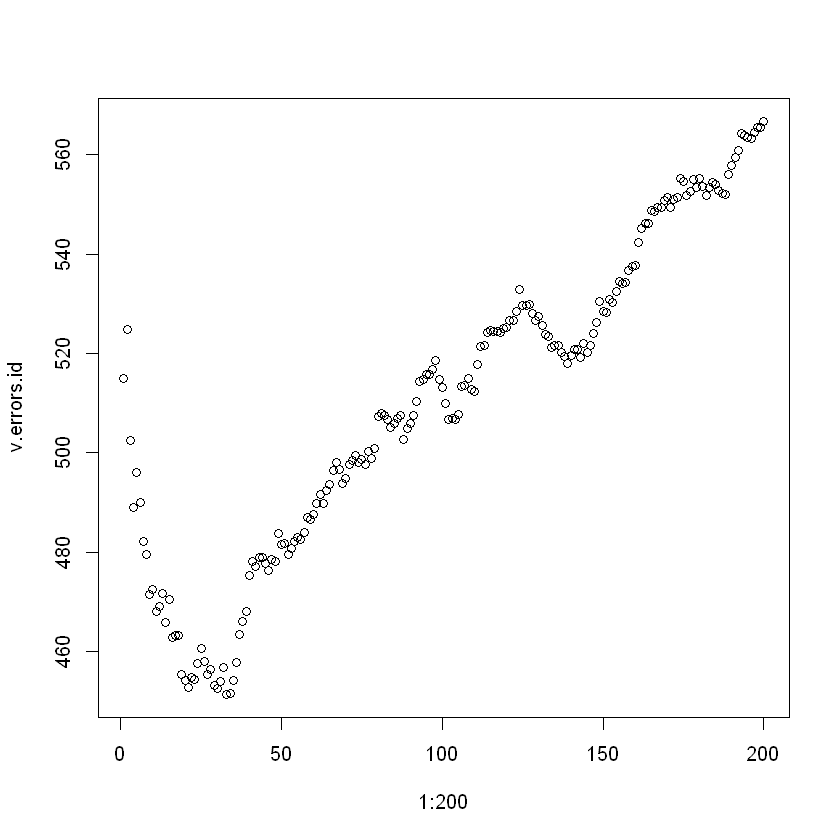

In [22]:
plot(1:200,v.errors.id)

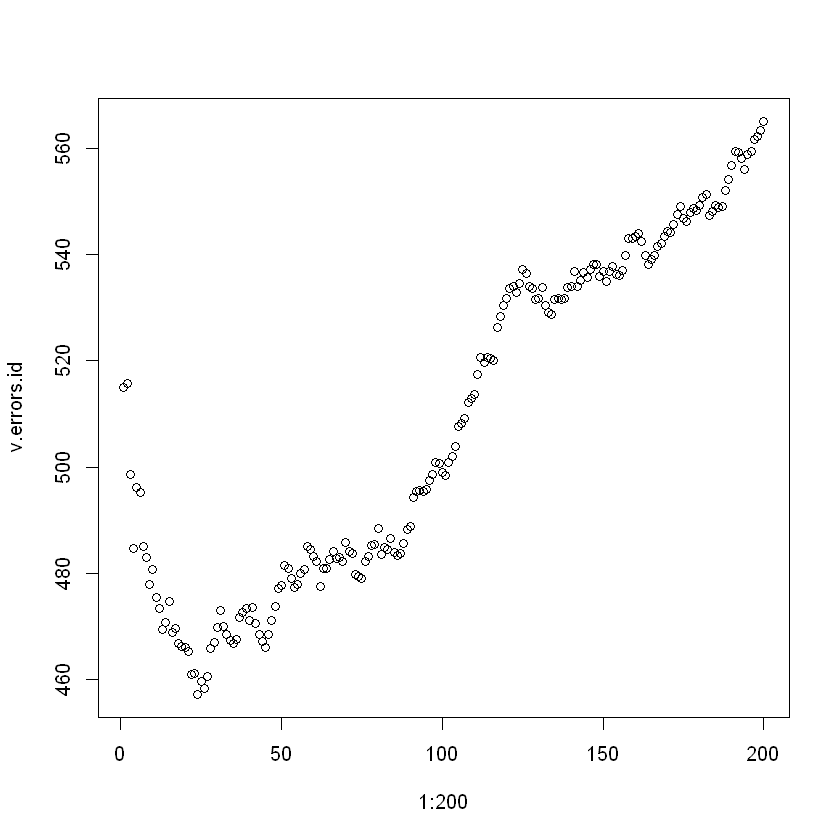

In [69]:
plot(1:200,v.errors.id)

## Regularization

In [24]:
data.train.process$Intensity <- as.numeric(data.train.process[,'Intensity'])

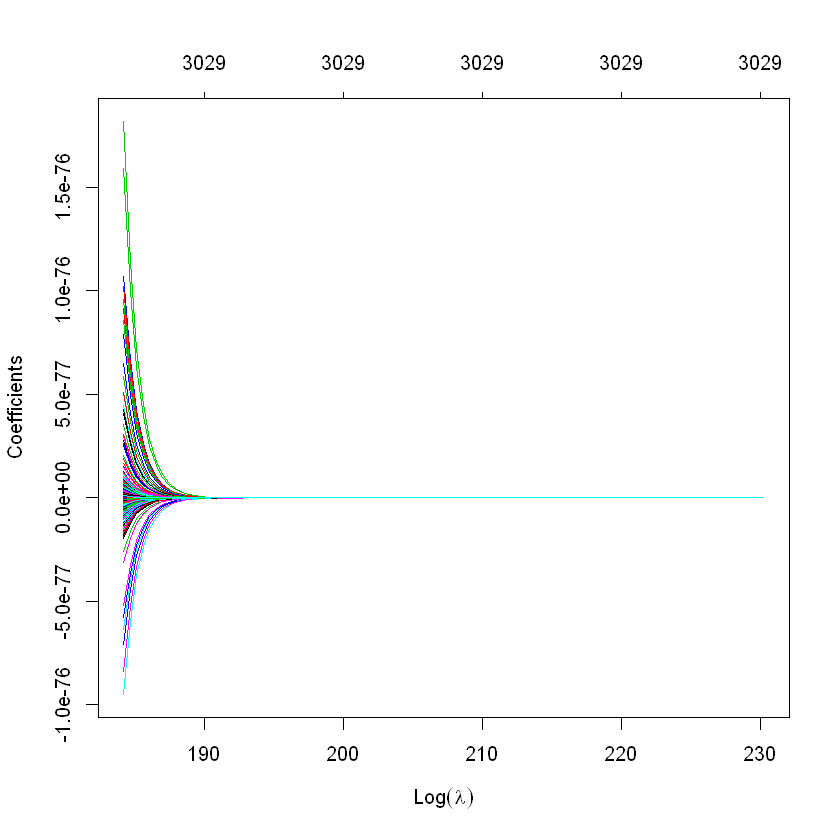

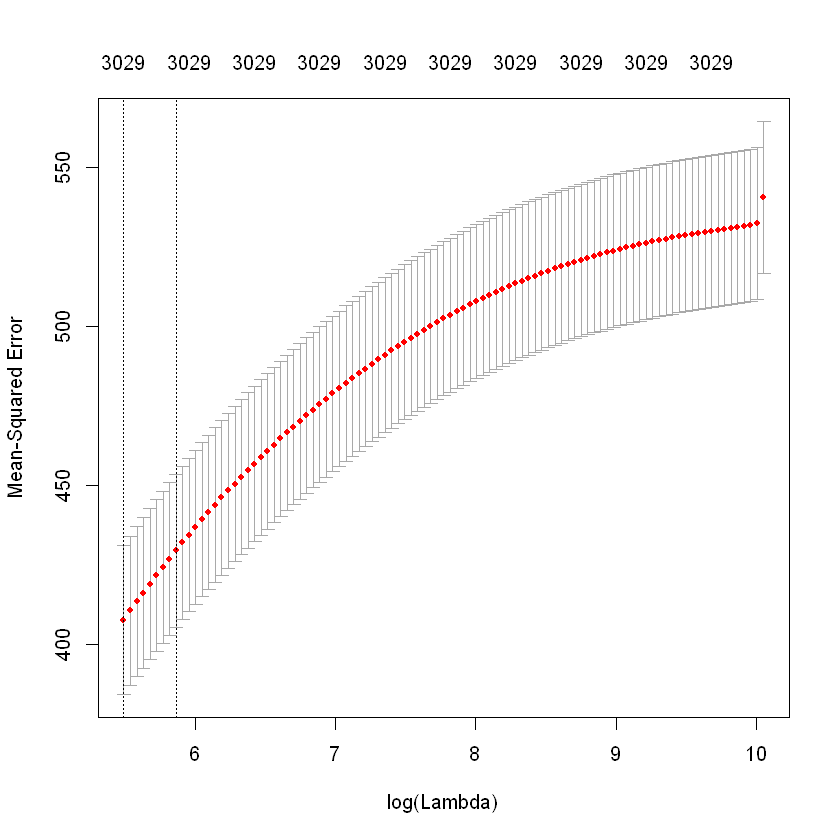

In [43]:
y <- data.train.process$VALENCE.PLEASANTNESS
x <- as.matrix(data.train.process)
L2 <- glmnet(x, y, alpha = 0, lambda = 10^seq(100,80, length = 100))
plot(L2, "lambda", xlab = parse(text = "Log(lambda)"))
L2.cv <- cv.glmnet(x, y, alpha = 0, nfold = 20)
plot(L2.cv)

In [2]:
T <- train.regr
T$Intensity <- as.numeric(train.regr[,'Intensity'])

In [8]:
y <- T$VALENCE.PLEASANTNESS
x <- as.matrix(T)

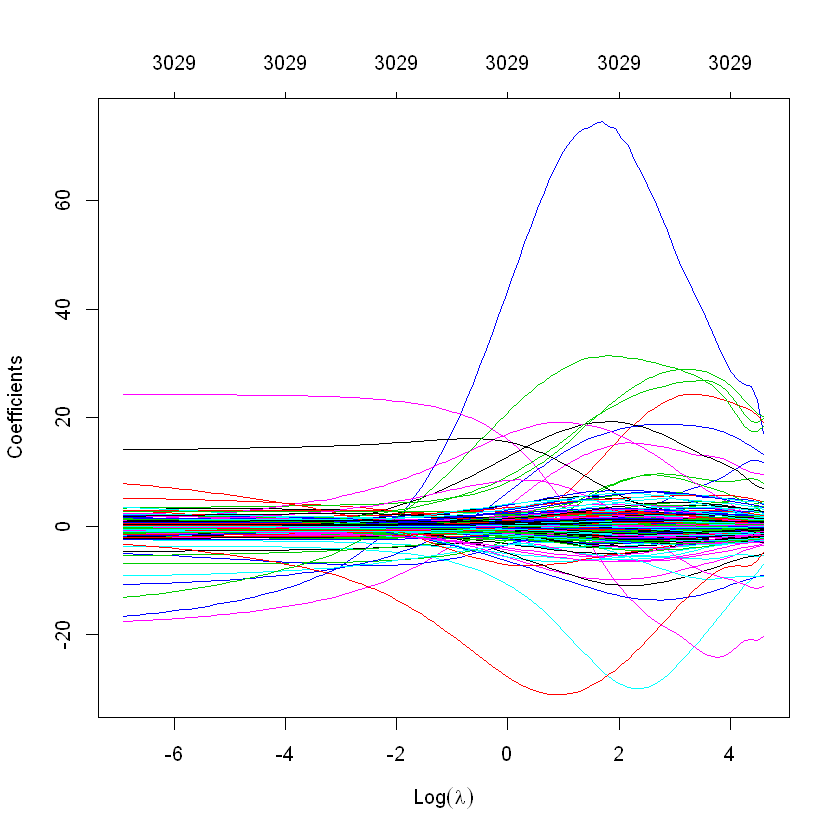

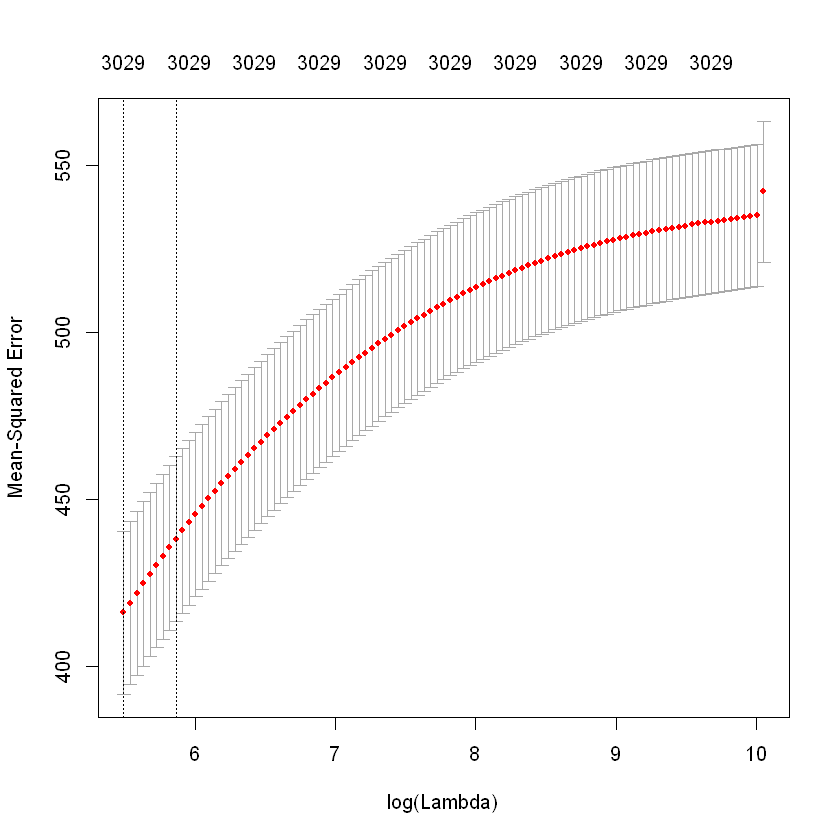

In [10]:

L2 <- glmnet(x, y, alpha = 0, lambda = 10^seq(2,-3, length = 100))
plot(L2, "lambda", xlab = parse(text = "Log(lambda)"))
L2.cv <- cv.glmnet(x, y, alpha = 0, nfold = 10)
plot(L2.cv)

LASSO

Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"

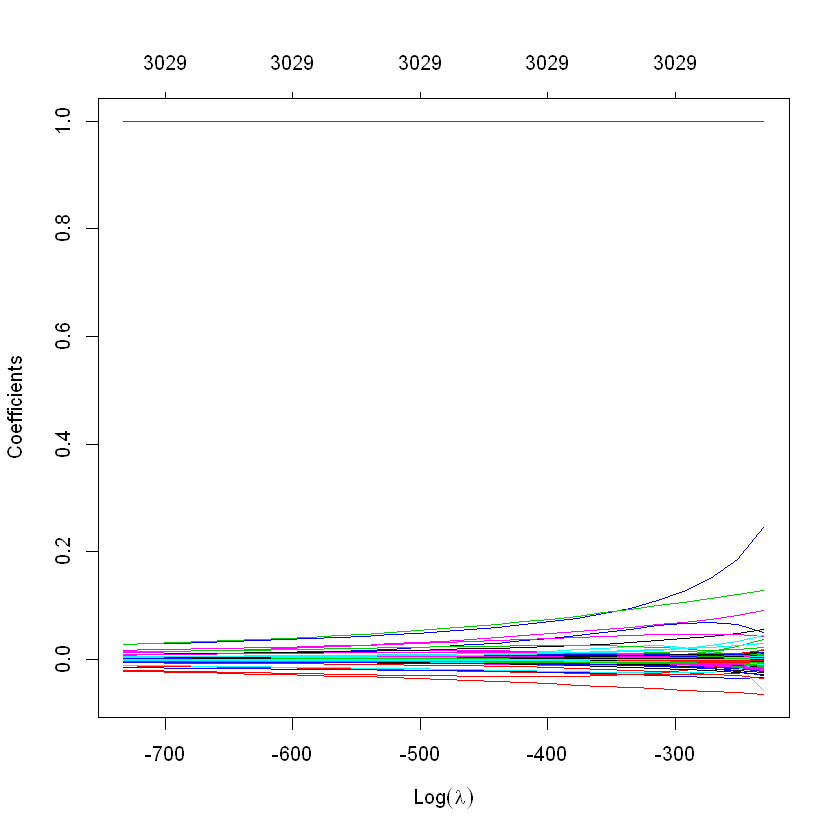

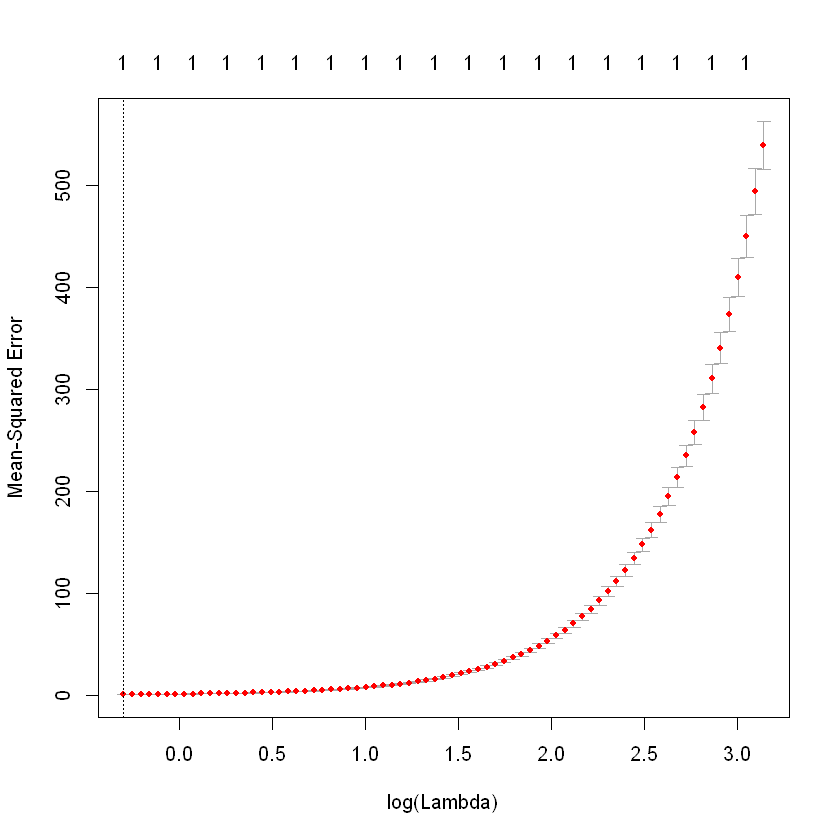

In [78]:
#train$Intensity <- as.numeric(train[,'Intensity'])
x <- as.matrix(T)

L1 <- glmnet(x, y, alpha = 1, lambda = 10^seq(-100, -1000, length = 100))
plot(L1, "lambda", xlab = parse(text = "Log(lambda)"))
L1.cv <- cv.glmnet(x, y, alpha = 1, nfold = 20)
plot(L1.cv)

In [8]:
summary(linear.fit)


Call:
lm(formula = VALENCE.PLEASANTNESS ~ ., data = train.regr)

Residuals:
    Min      1Q  Median      3Q     Max 
-39.773  -9.074   0.023   9.023  51.477 

Coefficients: (4536 not defined because of singularities)
                         Estimate Std. Error t value Pr(>|t|)
(Intercept)             2.065e+06  6.496e+07   0.032    0.975
Intensitylow            2.045e+00  1.440e+00   1.420    0.156
complexity.from.pubmed -1.725e+02  1.308e+03  -0.132    0.895
MW                      1.082e+04  8.745e+04   0.124    0.902
AMW                     2.130e+03  4.750e+03   0.448    0.654
Sv                      1.179e+05  2.081e+05   0.567    0.571
Se                      5.495e+05  3.099e+06   0.177    0.859
Sp                     -2.213e+05  1.304e+06  -0.170    0.865
Si                      2.496e+05  2.421e+06   0.103    0.918
Mv                      1.039e+06  7.256e+06   0.143    0.886
Me                     -6.282e+05  4.891e+06  -0.128    0.898
Mp                     -2.202e+05  8.2